In [1]:
%load_ext watermark
%watermark -a "Bhavya Kohli" -v

Author: Bhavya Kohli

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.30.0



# MoNuSAC Instance Segmentation

<a class = "anchor" id="datalink"></a>
This notebook aims to create a Mask-RCNN model using the MoNuSAC data available [**here**](https://monusac-2020.grand-challenge.org/Data/). Due to deprecation issues it is recommended to run this notebook in a virtual environment following the steps described in this [**README**](https://github.com/BhavyaKohli/MoNuSAC-Instance-Segmentation) (available in the repository).

# Contents <a id="top"></a>

1. [Extracting the Data](#extraction)
2. [Exploring the Extracted Data](#exploration)
3. [Using the Mask-RCNN model on the Data](#ml) <br>
    3.1. [Defining the Dataset class](#def_dataset) <br>
    3.2. [Defining the Model Configuration](#def_config) <br>
    3.3. [Defining the Model](#def_model) <br>
    3.4. [Analysis of the trained model](#analysis) <br>

We first confirm the versions of the main libraries, i.e. tensorflow (should be 1.15.0), keras (should be 2.2.5) and h5py (should be 2.10.0). 

In [2]:
%watermark -p tensorflow,keras,h5py

tensorflow: 1.15.0
keras     : 2.2.5
h5py      : 2.10.0



Using TensorFlow backend.


We then run the following cell to silence tensorflow deprecation warnings, since most of the functions and utilities used internally in the mask-rcnn library are deprecated in tensorflow versions 2.x

In [3]:
import tensorflow as tf

# Silence deprecated-function warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

After downloading the MoNuSAC data mentioned [here](#datalink), extract it to the same directory as the `monusac.ipynb` notebook
The structure of the working directory at this point should be:
```
.
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
├───monusac_utils.py
└───monusac.ipynb (current notebook)
```

In [4]:
# Importing required libraries
import os, glob, pathlib
import numpy as np                      
import matplotlib.pyplot as plt

# For creating progress bars for "for" loops
import tqdm.notebook as tq          

A separate python file containing all created utility functions has been created. We import all those functions using the following cell:  

In [5]:
from monusac_utils import *

## Extracting the Data <a id="extraction"></a>
[Back to top](#top)

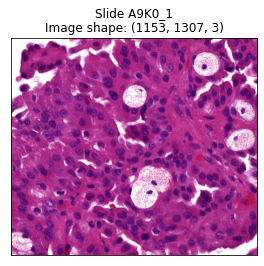

In [6]:
# Displaying a slide image using the above defined function
# using the sample slides in the sample_original directory.
sample_slides = glob.glob('./sample_original/*.svs')
img = from_svs(sample_slides[0], display = True, ax = plt.subplots()[1])

In [7]:
# Using the above defined function to store masks, slides, and annotations for
# 5 patients in the "data" folder (using default arguments)
data_path = './MoNuSAC_images_and_annotations/'

generate_and_save_masks(
    src = data_path,
    RESET=False,
    dst='./data',
    slides=False,
    masks=True,
    annots=False
)

Directory ./data already exists
Destination directories already exist. Please rename or delete in case of conflicting names.
209 slides are present in ./data\slides
394 masks are present in ./data\masks
209 annotations are present in ./data\annots


In [8]:
PATIENT_IDS = [filename[:6] for filename in os.listdir('./data/slides')]

In [9]:
# A few samples of the values stored in PATIENT_IDS
PATIENT_IDS[:5]

['1594_1', '1594_2', '1594_3', '1594_4', '1594_5']

In [10]:
create_train_test_data(
    RESET = False,
    slides_dir = './data/slides/', 
    patient_ids = PATIENT_IDS, 
    train = True, train_size = 0.8, 
    out_dir = './final'
)

create_train_test_data(
    RESET = False,
    slides_dir = './data/slides/', 
    patient_ids = PATIENT_IDS, 
    train = False, train_size = 0.8, 
    out_dir = './final'
)

Directory ./final exists
Directory ./final\train exists
755 slides were created at ./final\train
755 masks were created at ./final\train
Directory ./final exists
Directory ./final\val exists
206 slides were created at ./final\val
206 masks were created at ./final\val


After running the above cell, the working directory should now have the following structure:

```
.
├───data
│   ├───annots
│   ├───masks
│   │   ├───1
│   │   ├───2
│   │   ├───3
│   │   ├───4
│   │   └───X (One annotation file has an erroneous labelling.
|   |          The directory is created, but will be empty)
│   └───slides
├───final
│   ├───train
│   │   ├───slides
│   │   └───masks
│   └───val
│       ├───slides
│       └───masks
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
├───monusac_utils.py
└───monusac.ipynb (current notebook)
```



## Exploring the extracted data <a id="exploration"></a>
[Back to top](#top)

In [11]:
# We create three lists containing paths for slides, masks and annotations.
# We can use these lists for creating plots for visualizing our data and the
# masks created using the `create_train_test_data` function

# Data locations
DATA_DIR = './final/'
ANNOTS_DIR = './data/annots/'

# Lists with paths
MASKS = [x.__str__() for x in pathlib.Path(DATA_DIR).glob('**/*.mask')]
MASK_IDS = [mask.split('\\')[-1][:-5] for mask in MASKS]
MASK_LABELS = [x.__str__() for x in pathlib.Path('./final/').glob('**/*.label')]

SLIDES = [x.__str__() for x in pathlib.Path(DATA_DIR).glob('**/*.png') if x.__str__().split('\\')[-1][:-4] in MASK_IDS]
IMAGE_IDS = [slide.split('\\')[-1][:-4] for slide in SLIDES if slide.split('\\')[-1][:-4] in MASK_IDS]

ANNOTS = [ANNOTS_DIR + filename for filename in os.listdir('./data/annots')]

In [12]:
SLIDES_uncropped = [x.__str__() for x in pathlib.Path('./data/').glob('**/*.png')]
MASKS_uncropped = [x.__str__() for x in pathlib.Path('./data/').glob('**/*.mask')]

In [13]:
find_in_list('7760_1', MASKS_uncropped)

['data\\masks\\2\\lym_7760_1.mask', 'data\\masks\\4\\neu_7760_1.mask']

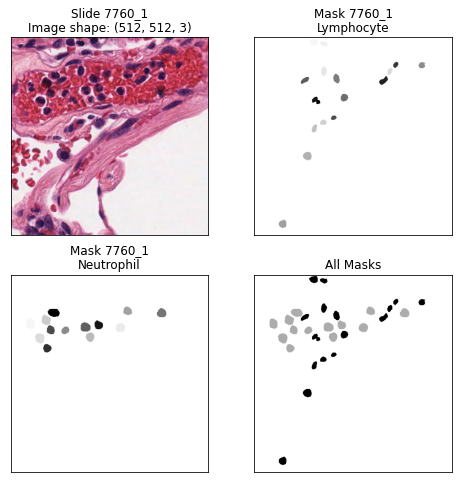

In [14]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
show_slide(find_in_list('7760_1', SLIDES_uncropped)[0], return_img = False, ax = axes[0,0], read_mode = 'cv2')
example_list = find_in_list('7760_1', MASKS_uncropped)

for i, loc in zip(example_list, [(0,1), (1,0)]):
    show_mask(i, return_mask = False, ax = axes[loc])
    
mask_1 = modify_mask_values(show_mask(example_list[0]), 0.7)
mask_2 = modify_mask_values(show_mask(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

clean_plot(all_in_one, axes[1,1], "All Masks", "Greys")
plt.show()

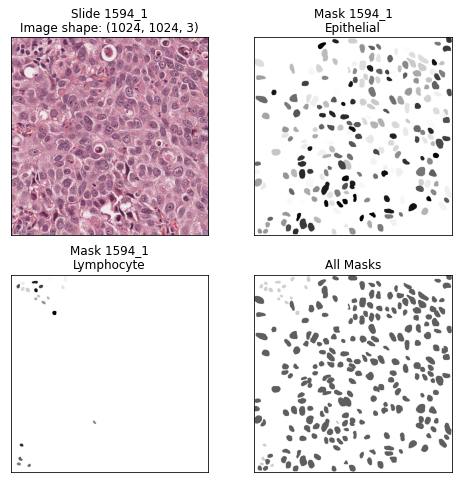

In [15]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
show_slide(find_in_list('1594_1', SLIDES_uncropped)[0], return_img = False, ax = axes[0,0], read_mode = 'cv2')
example_list = find_in_list('1594_1', MASKS_uncropped)

for i, loc in zip(example_list, [(0,1), (1,0)]):
    show_mask(i, return_mask = False, ax = axes[loc])
    
mask_1 = modify_mask_values(show_mask(example_list[0]), 0.7)
mask_2 = modify_mask_values(show_mask(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

clean_plot(all_in_one, axes[1,1], "All Masks", "Greys")
plt.show()

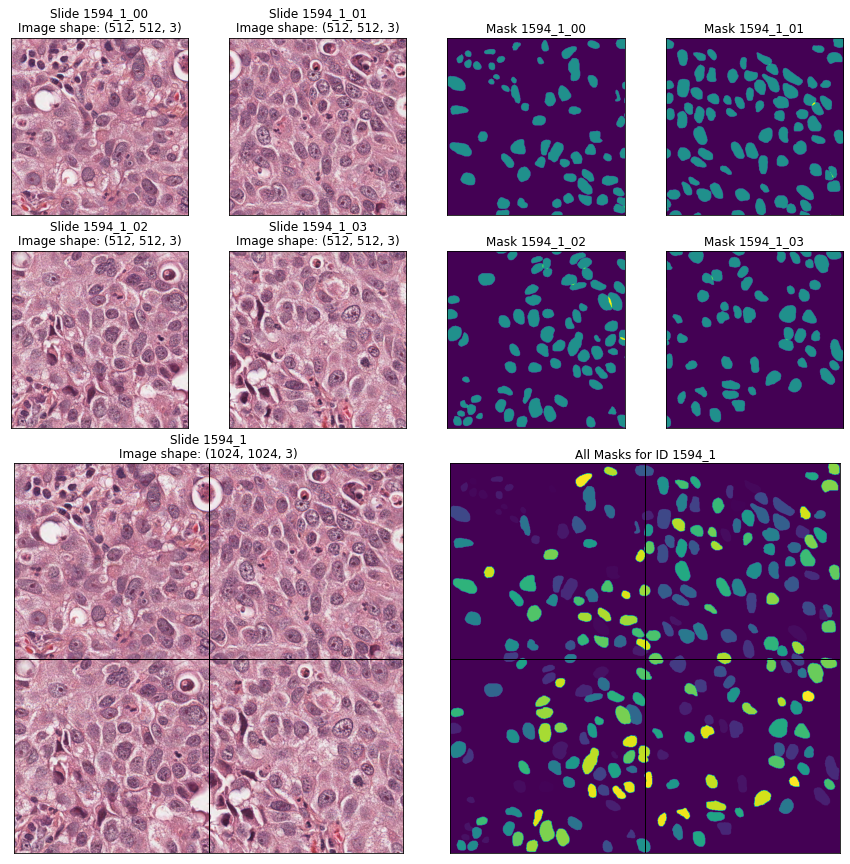

In [16]:
# Checking whether the cropped images are indeed correct by 
# comparing all subparts and the main image

fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(4, 4)

locs1 = [(0,0), (0,1), (1,0), (1,1)]
locs2 = [(0,2), (0,3), (1,2), (1,3)]

slide_axes = []
for slide, loc in zip(find_in_list('1594_1', SLIDES), locs1):
    slide_axes.append(fig.add_subplot(gs[loc]))
    show_slide(slide, return_img = False, read_mode = 'cv2', ax = slide_axes[-1])

mask_axes = []
for mask, loc in zip(find_in_list('1594_1', MASKS), locs2):
    mask_axes.append(fig.add_subplot(gs[loc]))
    show_mask(mask, return_mask = False, ax = mask_axes[-1], cmap = None)

total_slide = fig.add_subplot(gs[2:,:2])
show_slide(find_in_list('1594_1', SLIDES_uncropped)[0], return_img = False, ax = total_slide)
total_slide.axvline(512, color = 'black', linewidth = 1)
total_slide.axhline(512, color = 'black', linewidth = 1)

total_mask = fig.add_subplot(gs[2:,2:])
clean_plot(combine_masks(collect_masks_for_id('1594_1', MASKS_uncropped)), return_mask = False, ax = total_mask, title = "All Masks for ID 1594_1")
total_mask.axvline(512, color = 'black', linewidth = 1)
total_mask.axhline(512, color = 'black', linewidth = 1)

plt.show()

## Using the Mask-RCNN model on the data <a id="ml"></a>
[Back to top](#top)

In [17]:
# Importing required utilities from the mask-rcnn library
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import utils
from mrcnn.model import MaskRCNN
from mrcnn import visualize

### Defining the dataset class <a id="def_class"></a>

We now define the dataset class which inherits the base class utils.Dataset from the library. The load function is the basic function which will have to be run each time a dataset is created using this class. It adds all the necessary information about images such as image id, location of annotations, location of slides, etc. to the dataset. All these will then be used in the load_mask and load_image functions (internally) to add the images themselves to the dataset.

In [18]:
class MonuData(utils.Dataset):

    def load(self, train):
        type = 'train' if train else 'val'
        MASKS_DIR = f'./final/{type}/masks/'
        SLIDES_DIR = f'./final/{type}/slides/'

        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")

        slides_list = os.listdir(SLIDES_DIR)
        train_len = int(0.8 * len(slides_list))

        for filename, idx in zip(slides_list, np.arange(len(slides_list))):
            image_id = idx
            patient_id = filename.split('.')[0][:4] 
            img_path = os.path.join(SLIDES_DIR, filename)
            mask_path = os.path.join(MASKS_DIR, filename.split('.')[0] + '.mask')
            mask_labels_path = os.path.join(MASKS_DIR, filename.split('.')[0] + '.label')

            if train and idx > train_len:
                continue
            if not train and idx < train_len + 1:
                continue
            
            self.add_image('cell', 
                           image_id = image_id, 
                           patient_id = patient_id, 
                           path = img_path, 
                           mask = mask_path,
                           mask_labels = mask_labels_path)
    
    def load_image(self, image_id, ax = None):
        info = self.image_info[image_id]
        slide_path = info['path']
        img = show_slide(slide_path, read_mode = 'cv2')
        return img

    def load_mask(self, image_id, mask_filter = 'all'):
        info = self.image_info[image_id]
        mask_path = info['mask']
        mask_label_path = info['mask_labels']

        mask = show_mask(mask_path)
        mask_labels = feather.read_dataframe(mask_label_path).values 

        filtered_mask, filtered_labels = filter_cropped_mask(mask, mask_labels, mask_filter)
        return filtered_mask.astype(bool), np.array(filtered_labels).reshape(-1,)

    def num_cells(self, image_id, mask_filter = 'all'):
        info = self.image_info[image_id]
        mask_path = info['mask']
        mask_label_path = info['mask_labels']

        mask = show_mask(mask_path)
        mask_labels = feather.read_dataframe(mask_label_path).values 

        _, filtered_labels = filter_cropped_mask(mask, mask_labels, mask_filter)
        return len(filtered_labels)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']#

In [19]:
# Creating the training dataset
train_dataset = MonuData()
train_dataset.load(train = True)
train_dataset.prepare()

# Creating the validation dataset
val_dataset = MonuData()
val_dataset.load(train = False)
val_dataset.prepare()

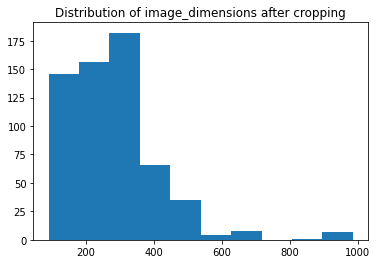

In [20]:
image_dims = [train_dataset.load_image(i).shape[0] for i in train_dataset.image_ids]
plt.hist(image_dims)
plt.title("Distribution of image_dimensions after cropping")
plt.show()

In [21]:
# Confirming that the load_mask function works as intended
load_mask_test = train_dataset.load_mask(2)
print(f"Shape of created mask: {load_mask_test[0].shape}", 
      f"Types of masks created: {np.unique([label_mapping[i] for i in load_mask_test[1]])}",
      f"Info about the image: {train_dataset.image_info[2]}", sep = '\n')

print(f"Total matches for the corresponding patient id in the masks archive:\n {find_in_list(train_dataset.image_info[2]['patient_id'], MASKS_uncropped)}")

Shape of created mask: (512, 512, 62)
Types of masks created: ['Epithelial' 'Lymphocyte']
Info about the image: {'id': 2, 'source': 'cell', 'path': './final/train/slides/1594_1_02.png', 'patient_id': '1594', 'mask': './final/train/masks/1594_1_02.mask', 'mask_labels': './final/train/masks/1594_1_02.label'}
Total matches for the corresponding patient id in the masks archive:
 ['data\\masks\\1\\epi_1594_1.mask', 'data\\masks\\1\\epi_1594_5.mask', 'data\\masks\\2\\lym_1594_1.mask', 'data\\masks\\2\\lym_1594_2.mask', 'data\\masks\\2\\lym_1594_3.mask', 'data\\masks\\2\\lym_1594_4.mask', 'data\\masks\\2\\lym_1594_5.mask', 'data\\masks\\3\\mac_1594_3.mask', 'data\\masks\\4\\neu_1594_4.mask']


As we can see above, masks for 2 types of cells are created using the train_dataset.load_mask function for that image, and there are exactly 2 types of cells whose masks are stored in MASKS_ALL (paths)

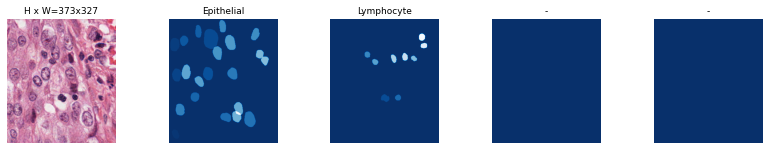

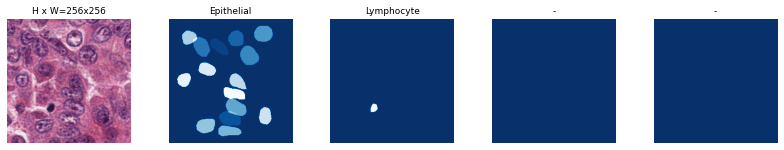

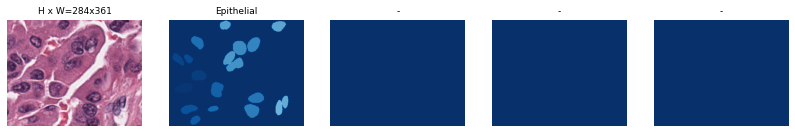

In [22]:
# Visualizing masks for a few slides using the "visualize" utility
image_ids = np.random.choice(train_dataset.image_ids, 3)
for image_id in image_ids:
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names)

### Defining the model configuration <a id="def_config"></a>

We inherit the base configuration class from mrcnn.config and override the default values according to the specs of our dataset. We have 4 cell types and so the number of classes have to be set to **5**, which is 1 (background) + 4 (number of unique cell types). Image minimum and maximum dimensions have been set to 256 each, looking at the dimension distribution in the histogram above. Minimum detection confidence has been set to 80% for training.

In [23]:
# Finding the mean R, G and B values of the images in the train dataset
ids = train_dataset.image_ids
RGB = np.zeros((len(ids),3))

for k in ids:
    img = train_dataset.load_image(k)
    RGB[k] = np.array([np.mean(img[:,:,2]), np.mean(img[:,:,1]), np.mean(img[:,:,0])])

In [24]:
np.mean(RGB, axis = 0)

array([167.05010884, 130.55218574, 175.80505586])

In [25]:
# Defining the configuration
class MonuConfig(Config):
    NAME = 'MoNuSAC'

    IMAGES_PER_GPU = 1 

    # Background + 4 cell types         
    NUM_CLASSES = 1 + 4

    # Setting steps per epoch as the length of the datasets
    STEPS_PER_EPOCH = len(train_dataset.image_ids)   
    VALIDATION_STEPS = len(val_dataset.image_ids)
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    MAX_GT_INSTANCES = 200
    DETECTION_MAX_INSTANCES = 200

    # Setting Mean values of R,G,B calculated above 
    MEAN_PIXEL = np.mean(RGB, axis = 0)         

    # Setting minimum confidence to 80%
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # Minimum image size
    IMAGE_MIN_DIM = 128

    # Maximum image size
    IMAGE_MAX_DIM = 256

    RPN_TRAIN_ANCHORS_PER_IMAGE = 150

cfg = MonuConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Defining the model and training it using the datasets created <a id="def_model"></a>

In [26]:
# loads model weights using this
MODEL_WEIGHTS_PATH = '../mask_rcnn_coco.h5'

# saves logs and checkpoint model weights in this directory
LOGS_PATH = './logs'

if not os.path.exists(MODEL_WEIGHTS_PATH):
    utils.download_trained_weights(MODEL_WEIGHTS_PATH)

In [28]:
# MODEL_WEIGHTS_PATH = find_in_list('0005', [x.__str__() for x in pathlib.Path('./logs').glob('**/*.h5')])[0]
# For continuing training, load the weights of the best saved model

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)

model.load_weights(
    MODEL_WEIGHTS_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
)

In [29]:
model.train(
    train_dataset = train_dataset, 
    val_dataset = val_dataset, 
    learning_rate = 10*cfg.LEARNING_RATE, 
    epochs = 5, 
    layer_verbosity = 0,
    layers = '3+'
)


Starting at epoch 0. LR=0.01

Checkpoint Path: ./logs\monusac20211218T1352\mask_rcnn_monusac_{epoch:04d}.h5


c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
605/605 [==============================] - 991s 2s/step - loss: 1.8242 - rpn_class_loss: 0.1376 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.4677 - mrcnn_bbox_loss: 0.3699 - mrcnn_mask_loss: 0.3502 - val_loss: 1.5384 - val_rpn_class_loss: 0.0662 - val_rpn_bbox_loss: 0.2895 - val_mrcnn_class_loss: 0.5662 - val_mrcnn_bbox_loss: 0.2943 - val_mrcnn_mask_loss: 0.3221
Epoch 2/5
605/605 [==============================] - 977s 2s/step - loss: 1.3595 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 0.3560 - mrcnn_class_loss: 0.3779 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 0.2936 - val_loss: 1.2095 - val_rpn_class_loss: 0.0519 - val_rpn_bbox_loss: 0.2859 - val_mrcnn_class_loss: 0.3415 - val_mrcnn_bbox_loss: 0.2466 - val_mrcnn_mask_loss: 0.2835
Epoch 3/5
605/605 [==============================] - 1456s 2s/step - loss: 1.1797 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.2996 - mrcnn_class_loss: 0.3138 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.2788 - val_loss: 1.0466 - val_rpn_class_los

In [27]:
MODEL_WEIGHTS_PATH = find_in_list('0005', [x.__str__() for x in pathlib.Path(LOGS_PATH).glob('**/*.h5')])[-1]
# For continuing training, load the weights of the saved model

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)

model.load_weights(
    MODEL_WEIGHTS_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
)

Re-starting from epoch 5


In [28]:
from keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = 'val_loss', patience = 3)

In [29]:
model.train(
    train_dataset = train_dataset, 
    val_dataset = val_dataset, 
    learning_rate = 2*cfg.LEARNING_RATE, 
    epochs = 15,
    layer_verbosity = 0, 
    layers = '3+',
    custom_callbacks = [es_callback]
)


Starting at epoch 5. LR=0.002

Checkpoint Path: ./logs\monusac20211218T1352\mask_rcnn_monusac_{epoch:04d}.h5


c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 6/15
605/605 [==============================] - 1077s 2s/step - loss: 0.8446 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.2555 - val_loss: 0.8807 - val_rpn_class_loss: 0.0402 - val_rpn_bbox_loss: 0.1966 - val_mrcnn_class_loss: 0.1900 - val_mrcnn_bbox_loss: 0.1885 - val_mrcnn_mask_loss: 0.2654
Epoch 7/15
605/605 [==============================] - 1001s 2s/step - loss: 0.6353 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2340 - val_loss: 0.8498 - val_rpn_class_loss: 0.0450 - val_rpn_bbox_loss: 0.2035 - val_mrcnn_class_loss: 0.1468 - val_mrcnn_bbox_loss: 0.1811 - val_mrcnn_mask_loss: 0.2734
Epoch 8/15
605/605 [==============================] - 999s 2s/step - loss: 0.5780 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2289 - val_loss: 0.8564 - val_rpn_class

### Further analysis and visualizations using the trained model <a id="analysis"></a>

In [27]:
from collections import Counter

In [41]:
# Defining a new configuration for Inference
class InferenceConfig(cfg.__class__):
    DETECTION_MIN_CONFIDENCE = 0.95

inf_cfg = InferenceConfig()

In [42]:
weights_list = find_in_list('0010', [x.__str__() for x in pathlib.Path(LOGS_PATH).glob('**/*.h5')])
print(*[(i,j) for i,j in enumerate(weights_list)], sep = '\n')
print("Input the index of the desired weights : ")
idx = int(input())

# Using the model weights from previous runs for model evaluation.
WEIGHTS_PATH = weights_list[idx]
print("Weights seleted :", WEIGHTS_PATH[5:])

# Defining model in 'inference' mode
model_trained = MaskRCNN(mode = 'inference', config = inf_cfg, model_dir = LOGS_PATH)
model_trained.load_weights(WEIGHTS_PATH, by_name = True)

(0, 'logs\\monusac20211205T0107\\mask_rcnn_monusac_0010.h5')
(1, 'logs\\monusac20211217T1831\\mask_rcnn_monusac_0010.h5')
(2, 'logs\\monusac20211218T1352\\mask_rcnn_monusac_0010.h5')
Input the index of the desired weights : 
Weights seleted : monusac20211218T1352\mask_rcnn_monusac_0010.h5
Re-starting from epoch 10


{'id': 201, 'source': 'cell', 'path': './final/val/slides/AAVK_3_15.png', 'patient_id': 'AAVK', 'mask': './final/val/masks/AAVK_3_15.mask', 'mask_labels': './final/val/masks/AAVK_3_15.label'}
image ID: 36, cell-201 ./final/val/slides/AAVK_3_15.png


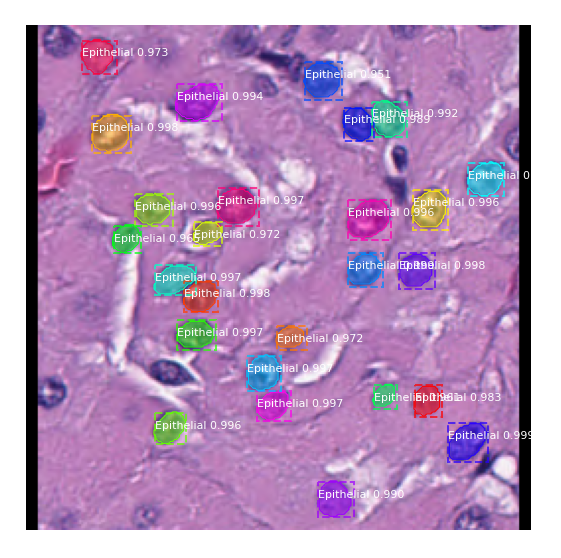

Cell types detected : {'Epithelial': 26}
Actual cell types present : {'Epithelial': 23}
Number of cells detected : 26
Actual number of cells present : 23
Original image and mask displayed below for comparison: 


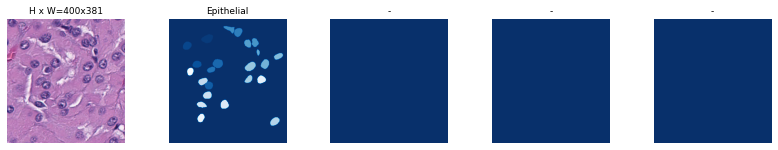

In [54]:
image_id = np.random.choice(val_dataset.image_ids)

image = modellib.load_image_gt(val_dataset, inf_cfg, image_id, use_mini_mask=False)[0]
info = val_dataset.image_info[image_id]
print(f"image ID: {image_id}, {info['source']}-{info['id']} {val_dataset.image_reference(image_id)}")
image_x, image_y = image.shape[:2]

results = model_trained.detect([image], verbose=0)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], val_dataset.class_names, r['scores'], figsize = (10,10))

# Loading the original image, mask and class_ids from the dataset
image = val_dataset.load_image(image_id)
mask, class_ids = val_dataset.load_mask(image_id)

actual_classes = dict(Counter([label_mapping[id] for id in class_ids]))
num_present = np.sum([actual_classes[key] for key in actual_classes.keys()])
result_classes = dict(Counter([label_mapping[id] for id in r['class_ids']]))
num_detected = np.sum([result_classes[key] for key in result_classes.keys()])

print(
    f"Cell types detected : {result_classes}",
    f"Actual cell types present : {actual_classes}",
    f"Number of cells detected : {num_detected}",
    f"Actual number of cells present : {num_present}",
    "Original image and mask displayed below for comparison: ",
    sep = '\n'
)

visualize.display_top_masks(image, mask, class_ids, val_dataset.class_names)

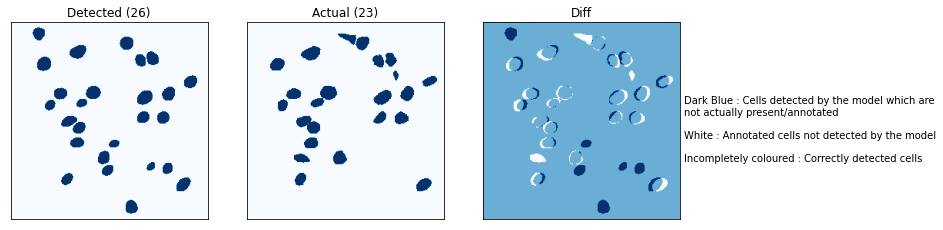

In [55]:
pred_mask = combine_masks(r['masks'])[:,:,0]
actual_mask = cv2.resize(combine_masks(mask), r['masks'].shape[:2])

_, ax = plt.subplots(1,3,figsize=(12,4))
clean_plot(pred_mask, ax[0], f"Detected ({num_detected})", cmap = "Blues")
clean_plot(actual_mask, ax[1], f"Actual ({num_present})", cmap = "Blues")
clean_plot(np.ones(r['masks'].shape[:2]) + pred_mask - actual_mask, ax[2], "Diff", cmap = "Blues")
ax[2].text(260, 120, "Dark Blue : Cells detected by the model which are\nnot actually present/annotated")
ax[2].text(260, 150, "White : Annotated cells not detected by the model")
ax[2].text(260, 180, "Incompletely coloured : Correctly detected cells")
plt.show()

## Misc. Testing

In [ ]:
image_id = 18 #np.random.choice(val_dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(val_dataset, inf_cfg, image_id, use_mini_mask=True)
info = val_dataset.image_info[image_id]
print(f"image ID: {image_id}, {info['source']}-{info['id']} {val_dataset.image_reference(image_id)}")
image_x, image_y = image.shape[:2]

#image = image[:image_x//2,:image_y//2]
results = model_trained.detect([image], verbose=1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], val_dataset.class_names, r['scores'])

In [ ]:
result_classes = dict(Counter([label_mapping[id] for id in r['class_ids']]))
print(
    f"Cell types detected : {result_classes}",
    f"Number of cells detected : {np.sum([result_classes[key] for key in result_classes.keys()])}",
    f"Types of masks in main directory : {find_in_list(val_dataset.image_info[image_id]['patient_id'], MASKS_ALL)}",
    f"Actual number of cells : {num_cells(val_dataset.image_info[image_id]['patient_id'], ANNOTS_DIR)}", sep = '\n'
)

In [ ]:
m = get_mask('1594_1')[0]
m.shape

In [ ]:
np.savetxt('txt.txt', m.flatten())

In [ ]:
import pandas as pd
import feather

In [ ]:
feather.write_dataframe(pd.DataFrame(m.flatten()), 'txt.feather')

64


  0%|          | 0/63 [00:00<?, ?it/s]

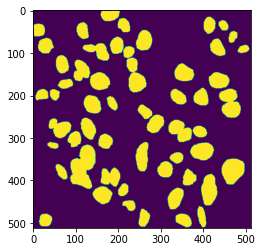

In [ ]:
plt.imshow(combine_masks(feather.read_dataframe('txt.feather').values.reshape(m.shape)))

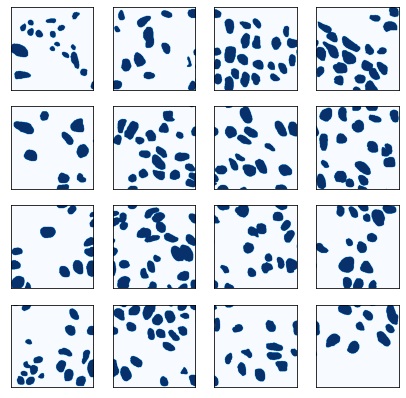

In [ ]:
masks = crop_mask(m, 256, 256)
_, axes = plt.subplots(4, 4, figsize = (7,7))

for i, j in zip(masks.keys(), [(i,j) for i in np.arange(4) for j in np.arange(4)]):
    clean_plot(combine_masks(masks[i]), axes[j], cmap = "Blues")

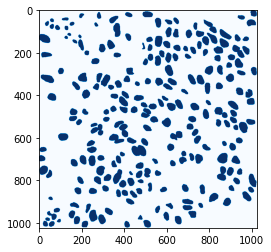

In [ ]:
plt.imshow(combine_masks(m), cmap = "Blues")

In [ ]:
mask = feather.read_dataframe('./ignore/test/train/masks/1594_1_02.feather').values.reshape(512,512,251)
filtered_mask, _ = filter_cropped_mask(mask, [1 for i in range(251)])

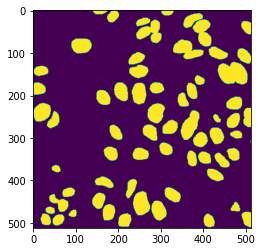

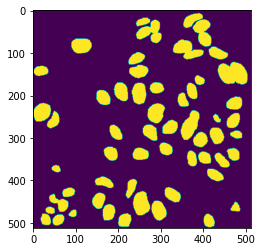

In [ ]:
plt.imshow(combine_masks(mask))
plt.show()
plt.imshow(combine_masks(filtered_mask))
plt.show()